Домашнее задание
Обучить генератор создавать точки, которые будут лежать на графике функции 𝑦=sin(𝑥)𝑥−𝑥10
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

In [1]:
# import os
import numpy as np
import math
import torch
import torch.nn as nn
# import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
# from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
class Data(Dataset):
    def __init__(self, func, min, max, num):
        self.num = num
        self.x = np.random.rand(num) * (max - min) + min
        self.func = func

    def __getitem__(self, idx):
        point = self.x[idx]
        # return torch.FloatTensor([point, self.func(point)])
        return torch.Tensor([point, self.func(point)])

    def __len__(self):
        return self.num

In [4]:
FUNC = lambda x: np.sin(x)/x - x/10
MIN = -15
MAX = 15
NUM = 10000
data = Data(FUNC, MIN, MAX, NUM)
data[0]

tensor([-11.0511,   1.0148])

In [5]:
data_loader = DataLoader(data, batch_size = 1000, shuffle=True)

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super().__init__()

        self.linear_1 = nn.Linear(latent_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.linear_1(x)
        x = torch.tanh(x)
        x = self.linear_2(x)      
        return x

In [7]:
class Discriminator(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()

    self.linear_1 = nn.Linear(2, hidden_dim)
    self.linear_2 = nn.Linear(hidden_dim, hidden_dim // 2)
    self.linear_3 = nn.Linear(hidden_dim // 2, 1)

  def forward(self, x): 
    
    x = self.linear_1(x)
    x = torch.relu(x)
    x = self.linear_2(x)
    x = torch.relu(x)
    x = self.linear_3(x)
    x = torch.sigmoid(x)
    return x

In [8]:
n_epochs = 1000  # количество эпох
lr = 0.01  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 1  # Размерность случайного вектора, который подается на вход генератору
hidden_dim = 64

In [9]:
generator = Generator(latent_dim, hidden_dim).to(device)
discriminator = Discriminator(hidden_dim).to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(    
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)   
)

optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [10]:
d_loss_history = []
g_loss_history = []

Epoch: 10; Discriminator_loss: 0.685; Generator_loss: 0.737


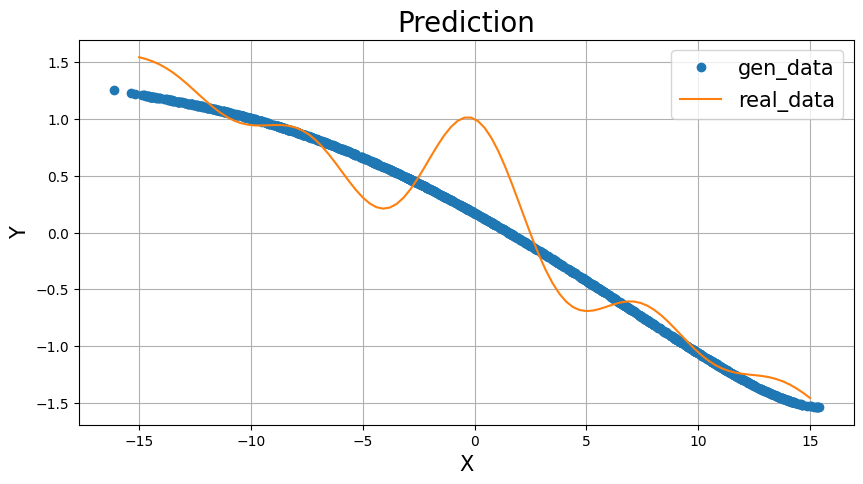

Epoch: 20; Discriminator_loss: 0.674; Generator_loss: 0.724


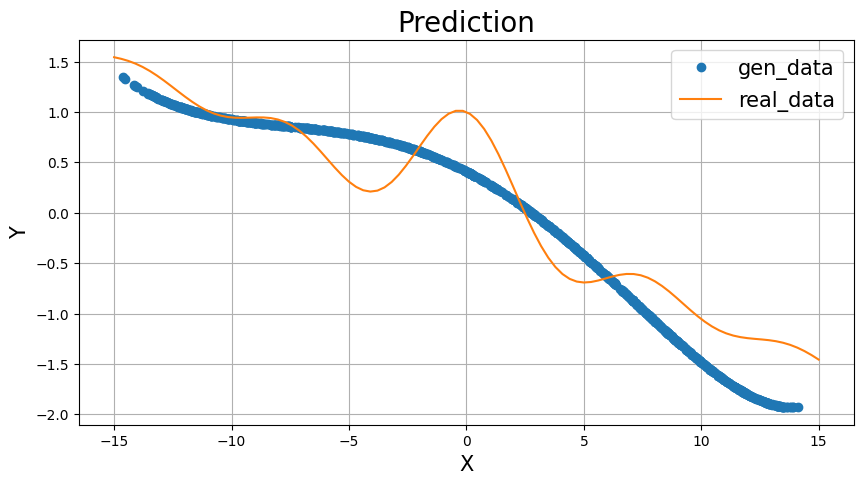

Epoch: 30; Discriminator_loss: 0.644; Generator_loss: 0.778


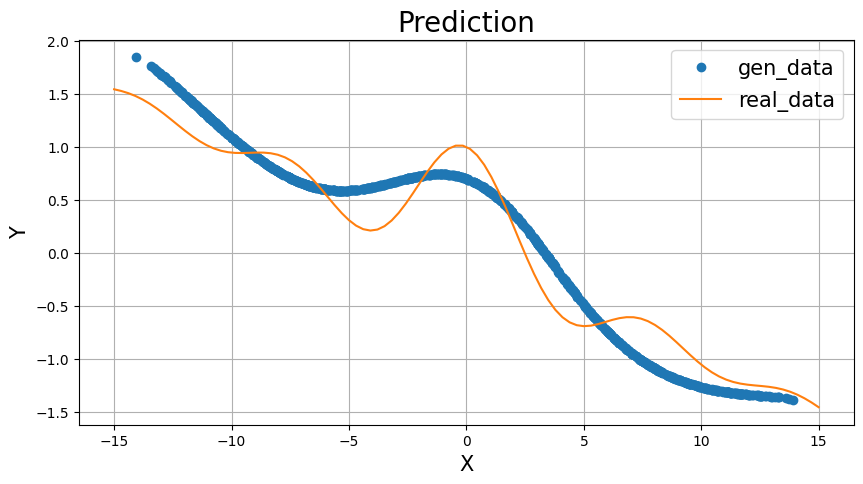

Epoch: 40; Discriminator_loss: 0.683; Generator_loss: 0.815


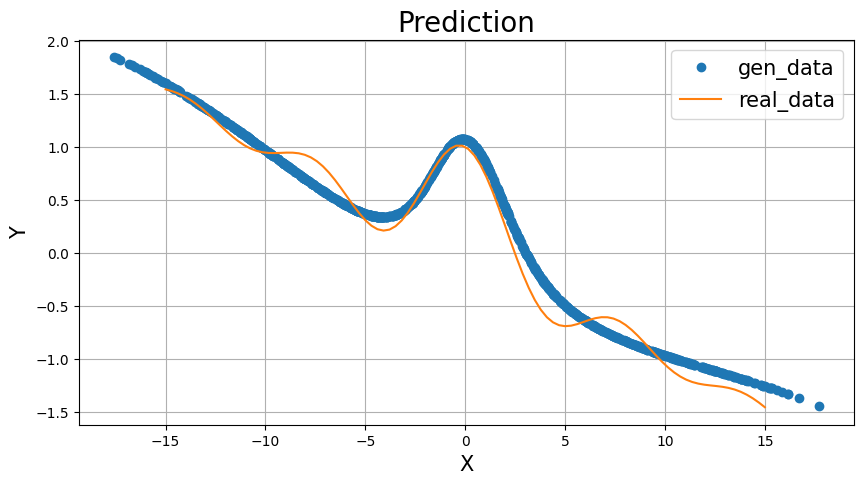

Epoch: 50; Discriminator_loss: 0.678; Generator_loss: 0.748


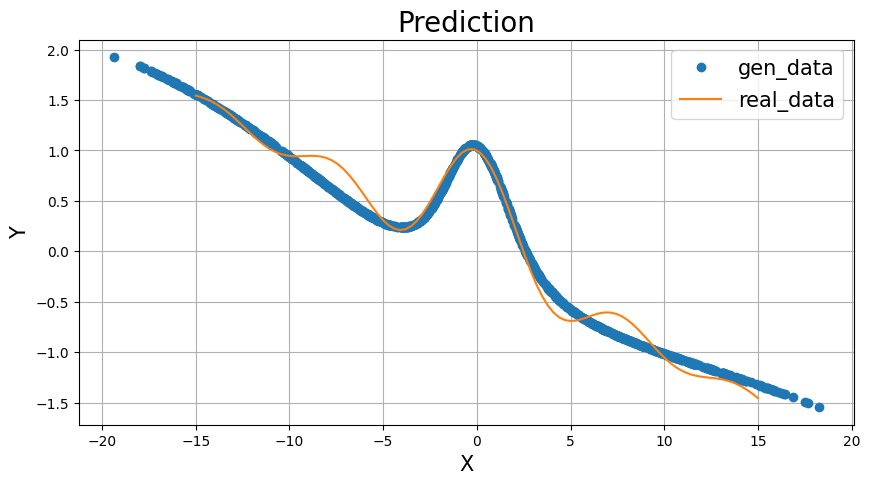

Epoch: 60; Discriminator_loss: 0.689; Generator_loss: 0.76


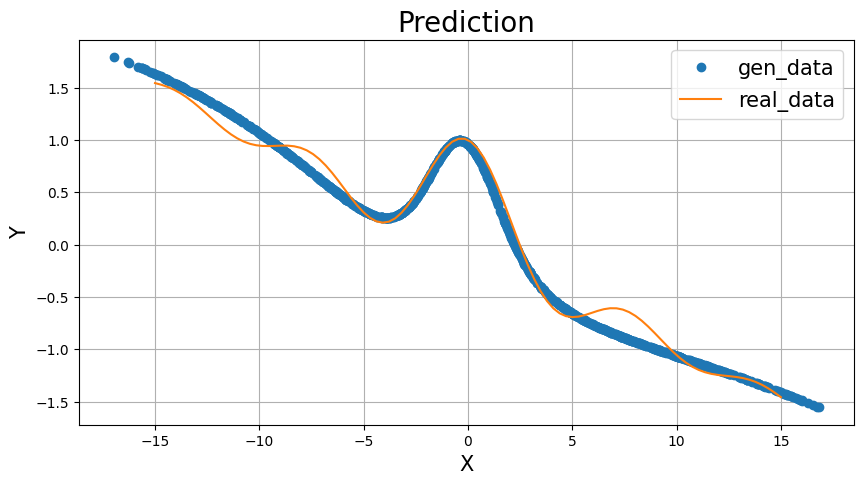

Epoch: 70; Discriminator_loss: 0.672; Generator_loss: 0.744


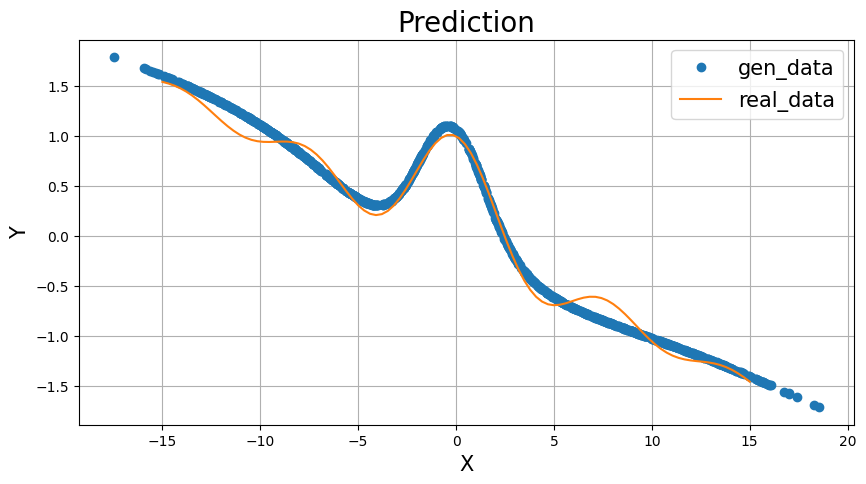

Epoch: 80; Discriminator_loss: 0.673; Generator_loss: 0.787


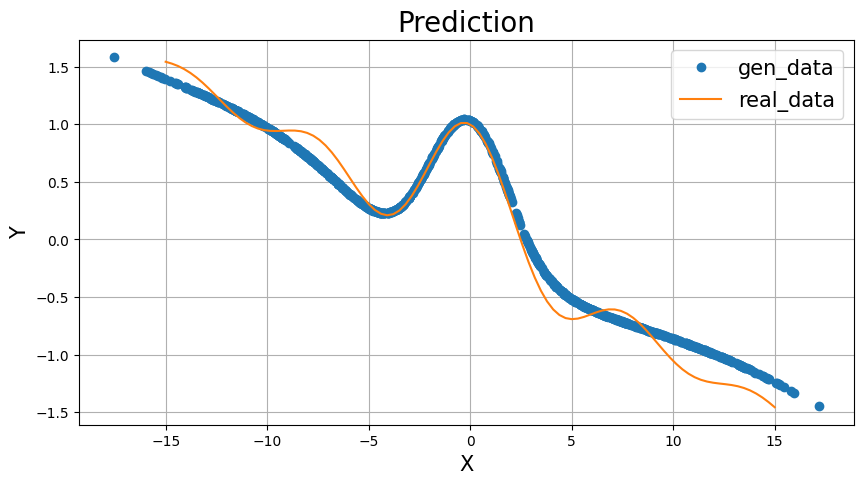

Epoch: 90; Discriminator_loss: 0.678; Generator_loss: 0.762


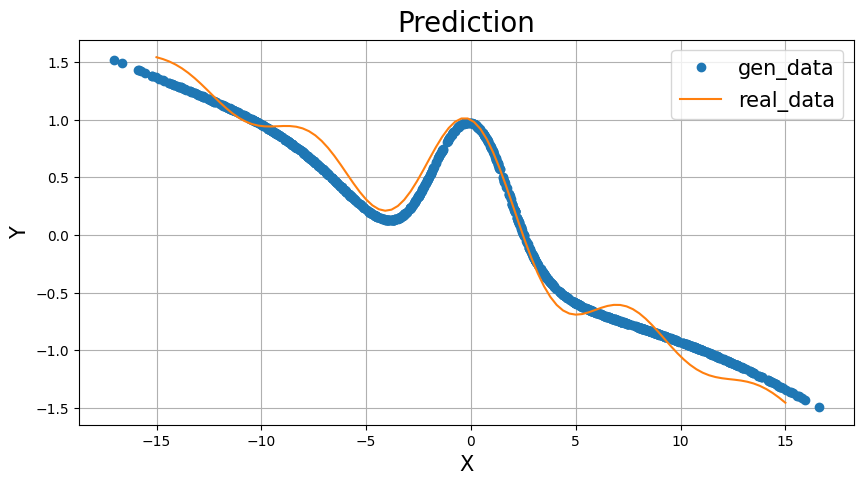

Epoch: 100; Discriminator_loss: 0.674; Generator_loss: 0.774


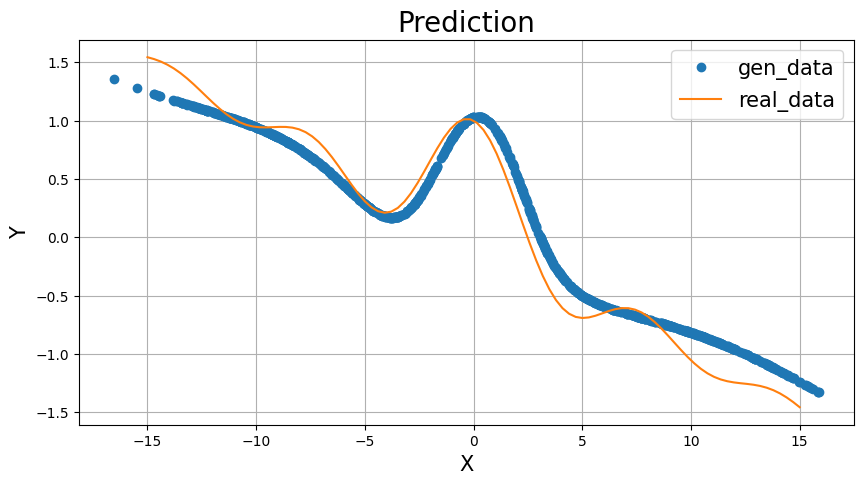

Epoch: 200; Discriminator_loss: 0.64; Generator_loss: 0.988


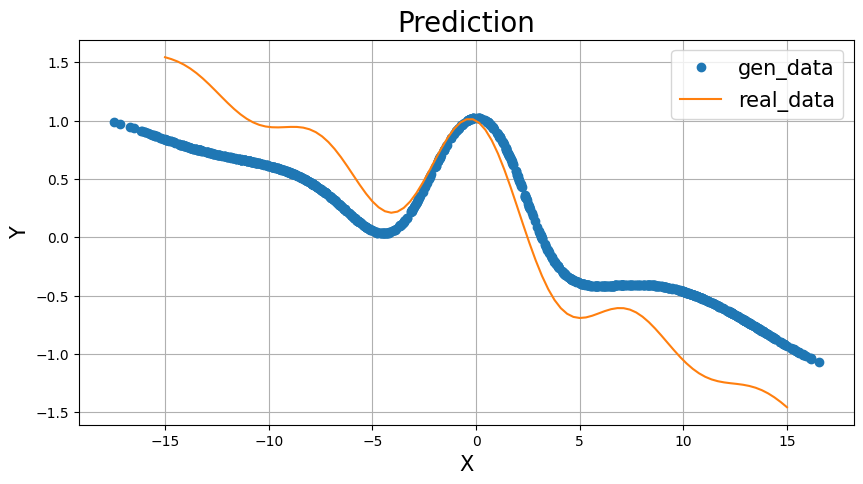

Epoch: 300; Discriminator_loss: 0.673; Generator_loss: 0.829


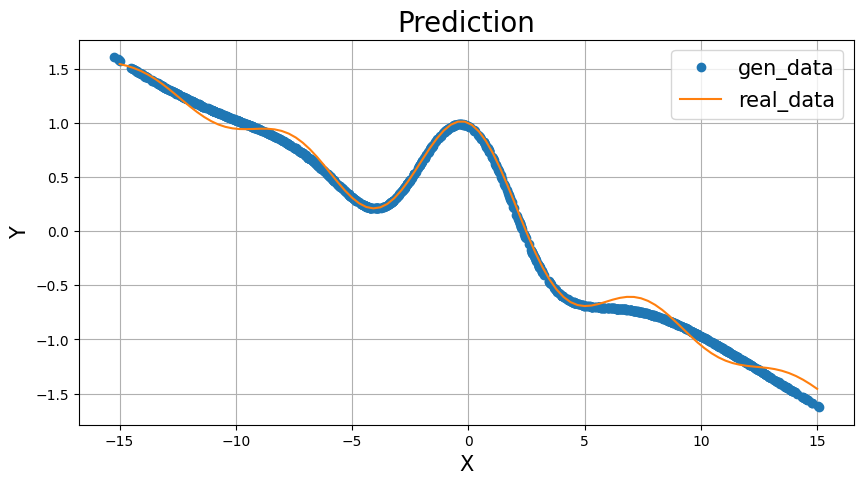

Epoch: 400; Discriminator_loss: 0.646; Generator_loss: 0.954


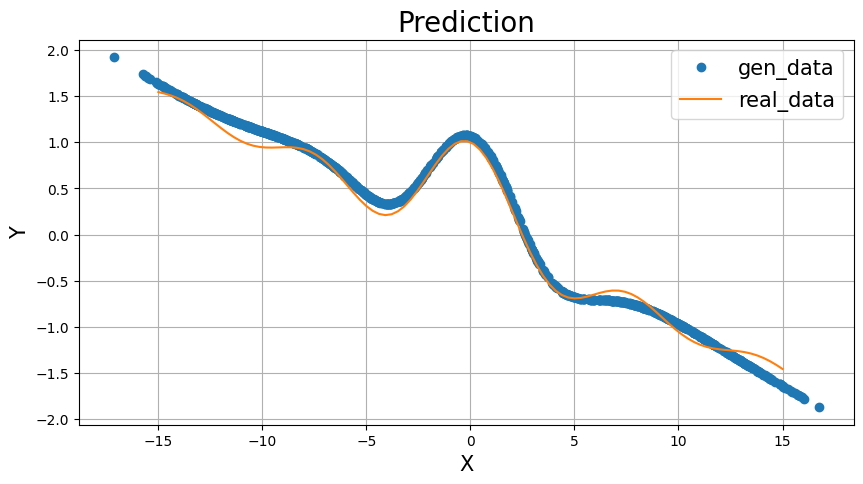

Epoch: 500; Discriminator_loss: 0.64; Generator_loss: 0.853


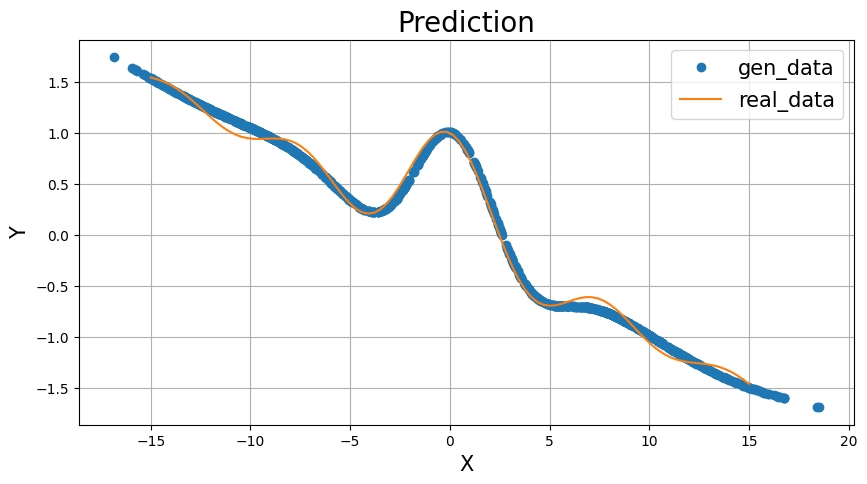

Epoch: 600; Discriminator_loss: 0.654; Generator_loss: 0.819


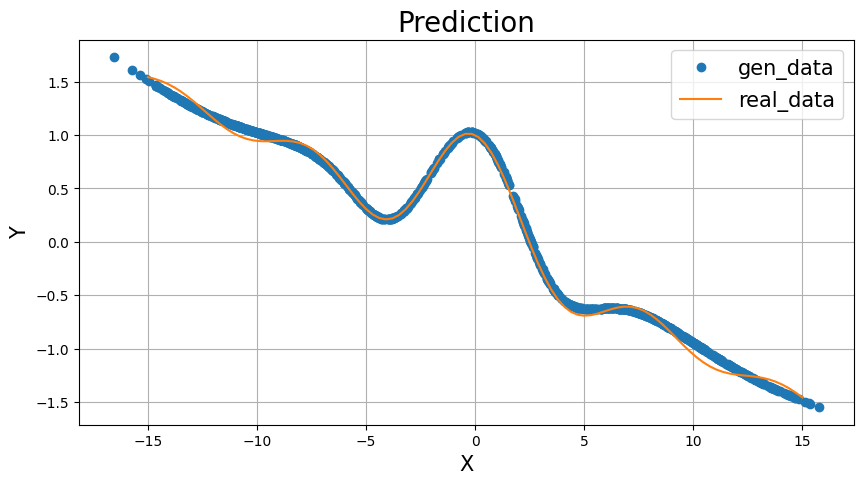

Epoch: 700; Discriminator_loss: 0.65; Generator_loss: 0.973


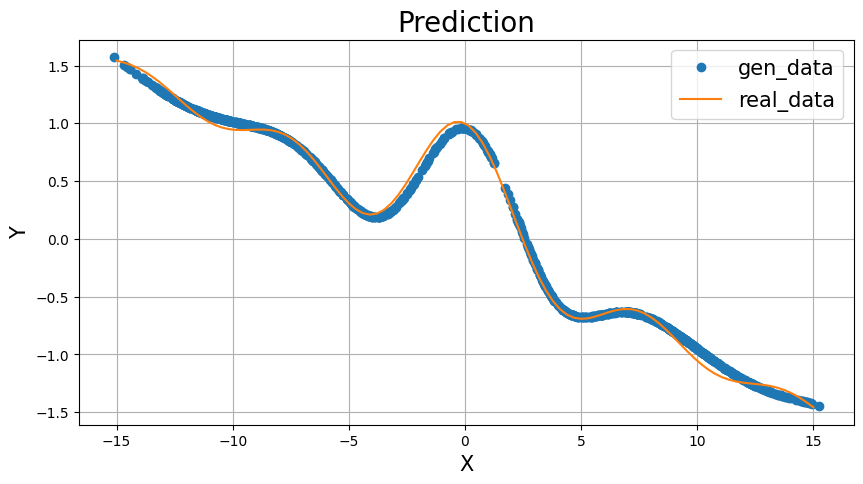

In [11]:
for epoch in range(n_epochs):    

    d_loss_mean = 0.0
    g_loss_mean = 0.0

    for data in data_loader:
        batch_size = len(data)
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.Tensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.Tensor(batch_size, 1).fill_(0.0).to(device)

        # real_data = data.type(torch.FloatTensor).to(device)
        real_data = data.type(torch.Tensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума        
        gen_data = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        # z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_data = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        d_loss_mean += d_loss.item()
        g_loss_mean += g_loss.item()
        
######## Отображение процесса обучения и вывод функций потерь ############
    if ((epoch + 1) % 10 == 0 and (epoch + 1) < 100)  or ((epoch + 1) % 100) == 0:
        print(f'Epoch: {epoch + 1}; '\
                f'Discriminator_loss: {round(d_loss_mean / len(data_loader), 3)}; '\
                f'Generator_loss: {round(g_loss_mean / len(data_loader), 3)}')
    
        plt.figure(figsize = (10,5))
        plt.title('Prediction', fontsize = 20)
        plt.grid(True)
        plt.ylabel('Y', fontsize = 15)
        plt.xlabel('X', fontsize = 15)

        gen_data = gen_data.cpu().detach().numpy()
        plt.plot(gen_data[:,0], gen_data[:,1], 'o', label='gen_data')

        plt.plot(np.linspace(MIN, MAX, 100), FUNC(np.linspace(MIN, MAX, 100)), label='real_data')

        plt.legend(fontsize = 15)
        plt.show()
    
    d_loss_history.append(d_loss_mean / len(data_loader))
    g_loss_history.append(g_loss_mean / len(data_loader))       

In [ ]:
plt.figure(figsize = (10,5))

plt.title('Loss', fontsize = 20)
plt.grid(True)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.plot(range(1, n_epochs+1), d_loss_history, label='Discriminator')
plt.plot(range(1, n_epochs+1), g_loss_history, label='Generator')
plt.legend(fontsize = 15);

В целом можно сказать, что у меня получилось научить генератор создавать точки из заданной функции. 